In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn

In [2]:
%matplotlib inline

In [3]:
def prettify(s):
    if s == s.upper():
        return s
    else:
        return s.capitalize()

In [4]:
adip_df = pd.read_excel("../Data/Growth_data/Supplementary-screening/adipate_ALE-KOs_102114.xlsx", sheetname="subtracted")
adip_df = adip_df.reset_index()
adip_df = adip_df[pd.notnull(adip_df["level_0"])]
adip_df["sample"] = adip_df["level_2"]
del adip_df["level_0"]
del adip_df["level_1"]
del adip_df["level_2"]
del adip_df["TIME [h] ->"]

adip_df["strain"] = adip_df["sample"].map(lambda x: x[:-2])
exclude_adip_samples = ["ADIP1-9_2"]
adip_df = adip_df[~adip_df["sample"].isin(exclude_adip_samples)]

exclude_adip = ["ADIP3-8", "ADIP7-5", "ADIP4-1", "ADIP3-4", "ADIP3-2", "ADIP7-2", "proV", "ybjL", "kgtP_ybjL", "kgtP_sspA"]
adip_df = adip_df[~adip_df["strain"].isin(exclude_adip)]


glut_df = pd.read_excel("../Data/Growth_data/Supplementary-screening/glutarate_ALE-KOs_102814.xlsx", sheetname="subtracted")
glut_df = glut_df.reset_index()
glut_df = glut_df[pd.notnull(glut_df["level_0"])]
glut_df["sample"] = glut_df["level_2"]
del glut_df["level_0"]
del glut_df["level_1"]
del glut_df["level_2"]
del glut_df["TIME [h] ->"]

glut_df = glut_df[~glut_df["sample"].isin(["nothing", "M9 blank"])]

glut_df["strain"] = glut_df["sample"].map(lambda x: x[:-2])
exclude_glut_samples = []
glut_df = glut_df[~glut_df["sample"].isin(exclude_glut_samples)]

exclude_glut = ["proV", "ybjL", "kgtP_ybjL", "kgtP_sspA"]
glut_df = glut_df[~glut_df["strain"].isin(exclude_glut)]



In [5]:
colors = ["#66358c", "#feba19", "#28a6e0", "#1c783c"]
label_dict = {
    "kgtP": "$\Delta$kgtP",
    "kgtP_proV": "$\Delta$kgtP $\Delta$proV",
    "kgtP_proV_ybjL": "$\Delta$kgtP $\Delta$proV $\Delta$ybjL",
    "pykF": "$\Delta$pykF",
    "ilvH": "MG1655 ilvH-L9F"
}

def plot_curves(df, last_label="", xmax=30, ymax=30, use_gray=True, strain_order=None):
    color_it = iter(colors)
    strain_means = df.groupby("strain").mean().transpose()
    strain_stds = df.groupby("strain").std().transpose() #/ 3**0.5
    if strain_order is None:
        columns = strain_means.columns
    else:
        columns = strain_order
    for i, strain in enumerate(columns):
        # plt.subplot(5, 5, i+1)
        # plt.title(strain)
        if use_gray and (strain.startswith("ADIP") or strain.startswith("GLUT") or strain.startswith("IBUA")):
            label = None
            color = "grey"
        else:
            label = strain
            color=next(color_it)
        plt.plot(strain_means.index, strain_means[strain].values, color=color, linewidth=3)
        plt.fill_between(
            strain_means.index.astype("float"),
            (strain_means[strain] + strain_stds[strain]).values,
            (strain_means[strain] - strain_stds[strain]).values,
            color=color,
            alpha=0.4
        )
        plt.fill_between([0, 0], [0, 0], color=color, label=label_dict.get(label, label))
    plt.fill_between([0, 0], [0, 0], color="grey", label=last_label)
    plt.ylim([-2, ymax])
    plt.xlim([0, xmax])
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel("Time (h)", fontsize=16)
    plt.ylabel("Cell density (a.u.)", fontsize=16)
    plt.grid(axis="y")

In [16]:
recon_df = pd.read_csv("../Data/Growth_data/Reconstructions/Reconstruction_dataframe.tsv", index_col=0, sep="\t")
recon_df["strain"] = recon_df["clean_strain"]
recon_exclude_strains = ["OCTA1-9", "OCTA2-14", "metJ_relA_clsA"]
recon_df = recon_df[~recon_df["strain"].isin(recon_exclude_strains)]

screen_df = pd.read_csv("../Data/Growth_data/evolved-isolate-growth-data/Evolved_isolates_data_frame.tsv", sep="\t")
screen_df = screen_df[screen_df["growth_rate"] != 0]
screen_df = screen_df.groupby(["compound", "strain"]).mean().reset_index()

In [17]:
compound_codes = {
    "1,2-propanediol": "12PD", "2,3-butanediol": "23BD", "HMDA": "HMDA",
    "putrescine": "PUTR", "glutarate": "GLUT", "adipate": "ADIP", "hexanoate": "HEXA",
    "octanoate": "OCTA", "coumarate": "COUM", "isobutyrate": "IBUA", "butanol": "BUT"
}

plot_compounts = [
    "1,2-propanediol", "2,3-butanediol", "HMDA", "putrescine", "glutarate", "adipate",
    "hexanoate", "octanoate", "coumarate", "isobutyrate", "butanol"
]

In [18]:
data = []

for i, comp in enumerate(plot_compounts):
    comp_df = recon_df[recon_df["compound"] == comp]
    baseline = float(comp_df[comp_df["strain"] == "MG1655"]["slope"].iloc[0])
    comp_df = comp_df[comp_df["strain"] != "MG1655"].copy()
    comp_df["slope"] = comp_df["slope"] - baseline
    ale_df = comp_df[comp_df["strain"].str.startswith(compound_codes[comp])].copy()
    for c in compound_codes.values():
        comp_df = comp_df[~comp_df["strain"].str.startswith(c)]
    comp_df = comp_df.copy()
    comp_df["type"] = "Reconstructed"
    ale_df["type"] = "ALE"
    #data.append(ale_df)
    ale_df = screen_df[screen_df["compound"] == comp]
    ale_mg_rate = ale_df[ale_df["strain"] == "MG1655"]["growth_rate"].mean()
    ale_df = ale_df[ale_df["strain"] != "MG1655"].copy()
    ale_df["slope"] = ale_df["growth_rate"] - ale_mg_rate
    ale_df["type"] = "ALE"
    data.append(comp_df)
    data.append(ale_df)

plot_df = pd.concat(data)

/Users/krisj/anaconda/envs/tolerance/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


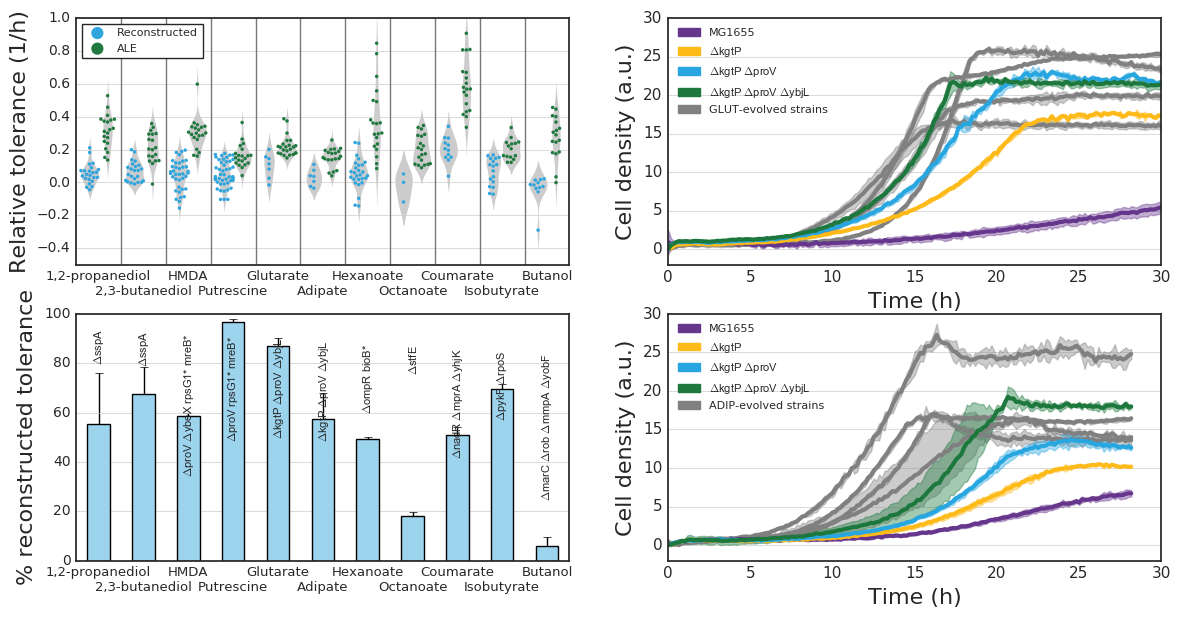

In [44]:
plt.style.use("seaborn-white")

fig = plt.figure(figsize=[14, 7])

mutant_names = {
    "sspA": "$\Delta$sspA",
    "metJ_relA_clsA": "$\Delta$metJ $\Delta$relA $\Delta$clsA",
    "rpsG1_mreB_ybeX": "$\Delta$proV $\Delta$ybeX rpsG1* mreB*",
    "rpsG1_mreB": "$\Delta$proV rpsG1* mreB*",
    "kgtP_proV_ybjL": "$\Delta$kgtP $\Delta$proV $\Delta$ybjL",
    "bioAB_ompR": "$\Delta$ompR bioB*",
    "stfE": "$\Delta$stfE",
    "nadR_mprA_yhjK": "$\Delta$nadR $\Delta$mprA $\Delta$yhjK",
    "pykF_rpoS": "$\Delta$pykF $\Delta$rpoS",
    "marC_rob_mppA_yobF": "$\Delta$marC $\Delta$rob $\Delta$mmpA $\Delta$yobF"
}

tick_fontsize = 11
legend_fs = 8


ax = fig.add_subplot(2, 2, 1)

plot_df_1 = plot_df.reset_index().copy()
plot_df_1 = plot_df_1.sort_values("type", ascending=False)
ordered_index = sorted(plot_df_1.index, key=lambda x: plot_compounts.index(plot_df_1.loc[x, "compound"]))
plot_df_1 = plot_df_1.reindex(ordered_index)


sbn.violinplot(
    x="compound", y="slope", hue="type", data=plot_df_1,
    inner=None, saturation=1, palette=["#cccccc"]*2, linewidth=0
)
sbn.swarmplot(
    x="compound", y="slope", hue="type", data=plot_df_1, palette=["#2fa5de", "#1f783e"],
    dodge=True, s=2.5
)

plt.xticks(rotation=90)
for i in range(11):
    plt.plot([i+0.5, i+0.5], [-.5, 1], "-", color="#777777")
plt.ylim([-0.5, 1])
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[2:], labels[2:], title=None, frameon=True, loc="upper left", fontsize=legend_fs)
plt.grid(axis="y")
plt.ylabel("Relative tolerance (1/h)", fontsize=16)
plt.xlabel("")

tick_labels = []
for i, n in enumerate(plot_compounts):
    tick_labels.append(prettify(n) + "\n" if i % 2 == 0 else "\n" + prettify(n))

plt.xticks(range(11), tick_labels, rotation=0, fontsize=9.5)


ax = fig.add_subplot(2, 2, 3)
test_df = plot_df.sort_values("slope", ascending=False)
plot_recon_df = test_df.groupby(["compound", "type"]).first().reset_index()
plot_recon_df = plot_recon_df[plot_recon_df["type"] == "Reconstructed"].set_index("compound")

plot_ale_df = test_df.groupby(["compound", "type"]).quantile(0.75).reset_index()
plot_ale_df = plot_ale_df[plot_ale_df["type"] == "ALE"].set_index("compound")

plot_recon_df = plot_recon_df.reindex(plot_compounts)
plot_ale_df = plot_ale_df.reindex(plot_compounts)

percentage_recon = (
    plot_recon_df["slope"] / plot_ale_df["slope"] * 100
).reindex([plot_compounts])
percentage_recon.plot(kind="bar", color="#9cd4ee")  # "#807dfc"

plt.errorbar(
    range(11),
    plot_recon_df["slope"] / plot_ale_df["slope"] * 100,
    plot_recon_df["stderr"] / plot_ale_df["slope"] * 100, 
    fmt=".",
    markersize=0,
    zorder=0,
    color="k"
)

for i, (k, v) in enumerate(percentage_recon.items()):
    label = plot_recon_df["strain"][k]
    plt.text(i-0.15, 90-i, mutant_names[label], rotation=90, fontsize=8)

tick_labels = []
for i, (k, v) in enumerate(percentage_recon.items()):
    label = plot_recon_df["strain"][k]
    tick_labels.append(prettify(k) + "\n" if i % 2 == 0 else "\n" + prettify(k) )#+ "\n(" + label + ")")
    
plt.ylim([0, 100])
plt.ylabel("% reconstructed tolerance", fontsize=16)
plt.xlabel("")
plt.grid(axis="y")
plt.xticks(range(11), tick_labels, fontsize=9.5, rotation=0)
None


plt.subplot(2, 2, 2)
plot_curves(glut_df, last_label="GLUT-evolved strains")
plt.legend(loc="upper left", fontsize=legend_fs)
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)

plt.subplot(2, 2, 4)
plot_curves(adip_df, last_label="ADIP-evolved strains")
plt.legend(loc="upper left", fontsize=legend_fs)
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)

None
#plt.tight_layout()
plt.savefig("../Plots/Figure 4 - Mechanisms.pdf", bbox_inches="tight")